In [1]:
#.................................................Training(dataset1).....................................................#
import os
import time
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings(action = 'ignore')

%matplotlib inline

In [2]:
tar = tarfile.open("fer2013.tar.gz")
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head(20)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
def getLabel(id):
    return ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'][id]

In [5]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [6]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [7]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [8]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [9]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [10]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

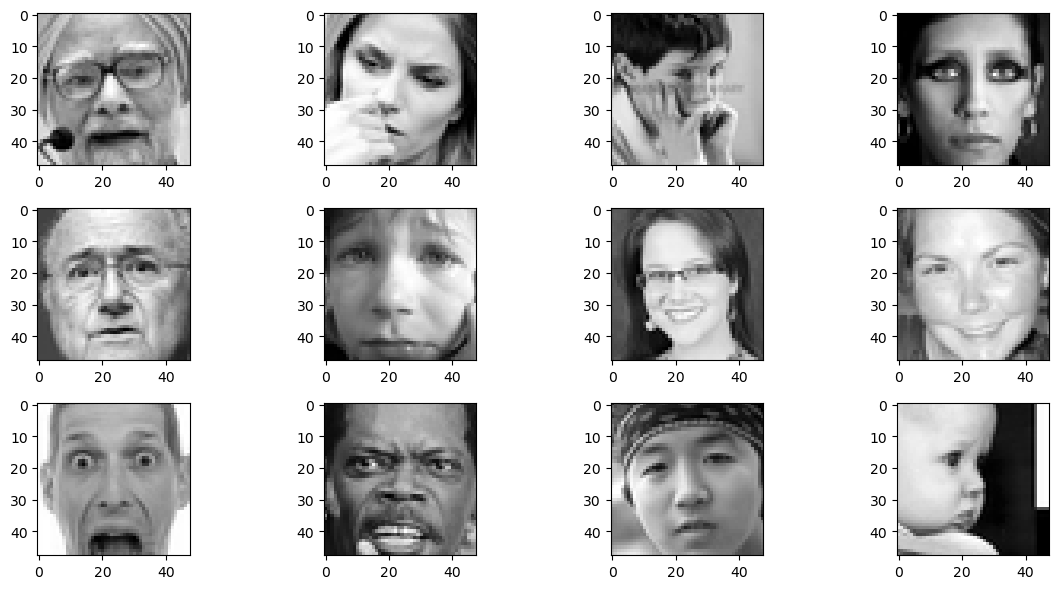

In [11]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

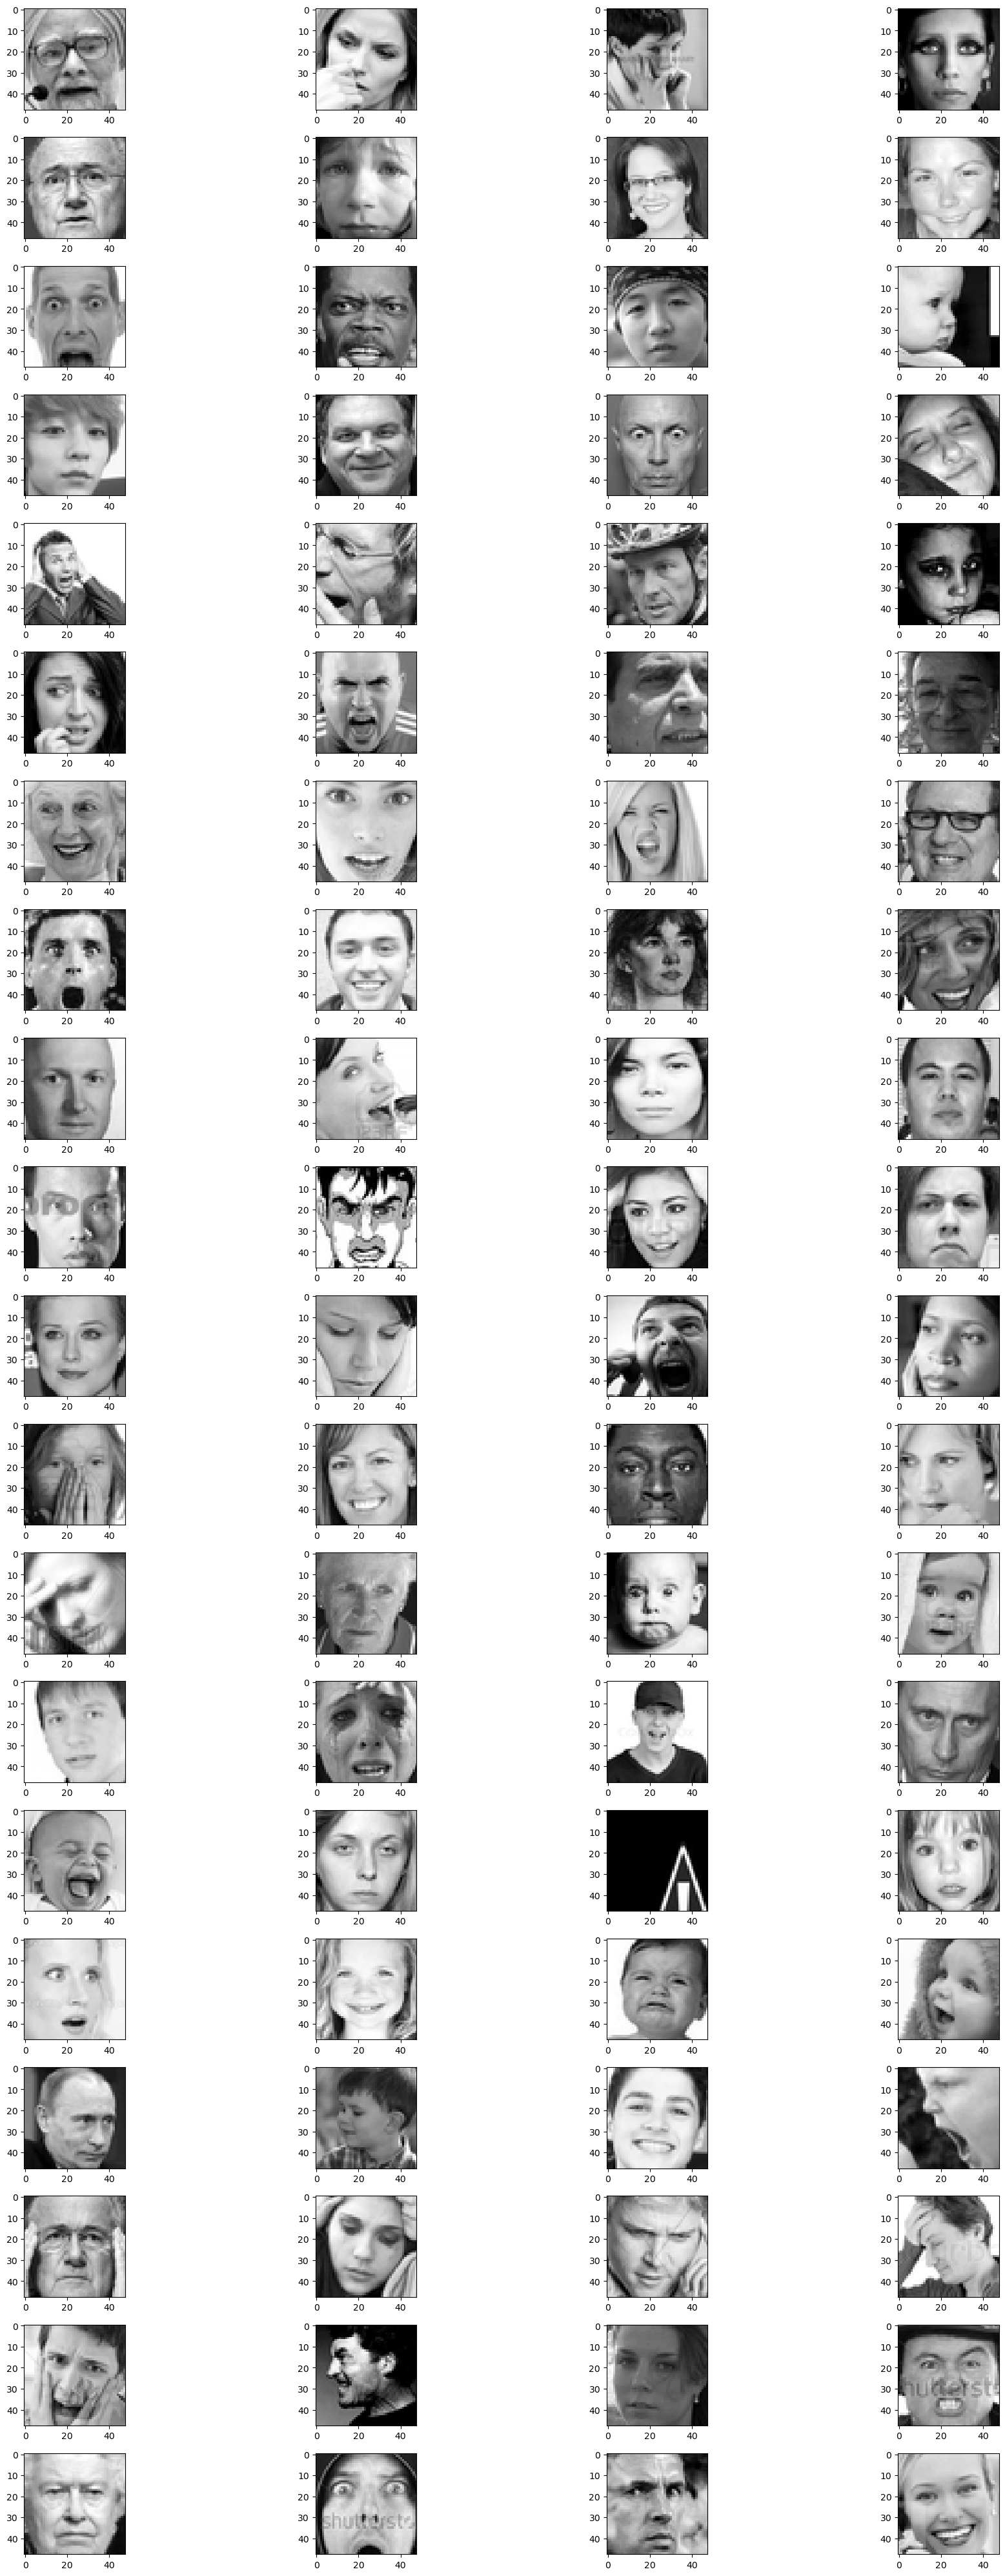

In [12]:
plt.figure(0, figsize=(20,40))
for i in range(1, 81):
    plt.subplot(20,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [13]:
model = Sequential()
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [14]:
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)
epochs = 10

hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.65569, saving model to face_model.h5
288/288 - 294s - loss: 2.0379 - accuracy: 0.2417 - val_loss: 1.6557 - val_accuracy: 0.3658 - 294s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_loss improved from 1.65569 to 1.55552, saving model to face_model.h5
288/288 - 290s - loss: 1.6830 - accuracy: 0.3401 - val_loss: 1.5555 - val_accuracy: 0.3929 - 290s/epoch - 1s/step
Epoch 3/10

Epoch 3: val_loss improved from 1.55552 to 1.44225, saving model to face_model.h5
288/288 - 252s - loss: 1.5523 - accuracy: 0.3965 - val_loss: 1.4423 - val_accuracy: 0.4366 - 252s/epoch - 877ms/step
Epoch 4/10

Epoch 4: val_loss improved from 1.44225 to 1.36142, saving model to face_model.h5
288/288 - 175s - loss: 1.4684 - accuracy: 0.4298 - val_loss: 1.3614 - val_accuracy: 0.4745 - 175s/epoch - 607ms/step
Epoch 5/10

Epoch 5: val_loss improved from 1.36142 to 1.32608, saving model to face_model.h5
288/288 - 205s - loss: 1.4145 - accuracy: 0.4548 - val_loss: 1.3261 - va

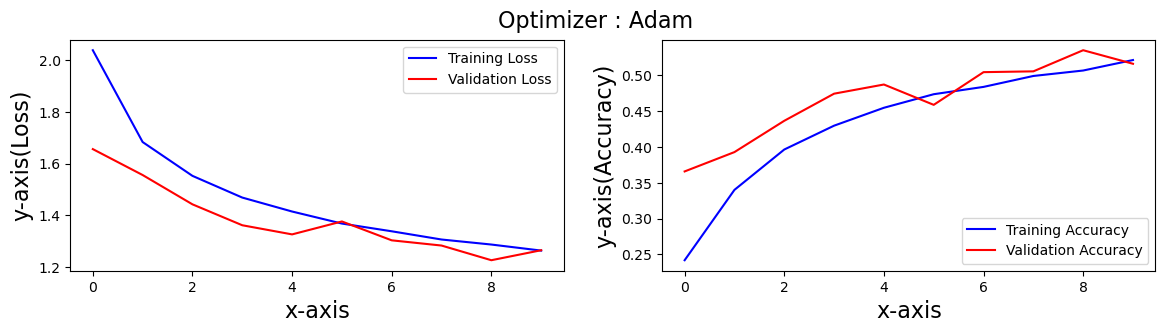

In [15]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=16)
plt.xlabel('x-axis', fontsize=16)
plt.ylabel('y-axis(Loss)', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('x-axis', fontsize=16)
plt.ylabel('y-axis(Accuracy)', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [17]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [18]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [24]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = x_test_private[0:1]
print (test_image.shape)

print(model.predict(test_image))
predictions = np.argmax(model.predict(test_image),axis=1)
print(predictions)
print(y_test_private[0:8])

Test Loss: 1.244005799293518
Test accuracy: 0.5071050524711609
(1, 48, 48, 1)
1/1 [==============================] - 0s 19ms/step
[[0.16723761 0.04971546 0.2661495  0.00735391 0.09267609 0.31641835
  0.10044911]]
1/1 [==============================] - 0s 29ms/step
[5]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


113/113 [==============================] - 5s 40ms/step


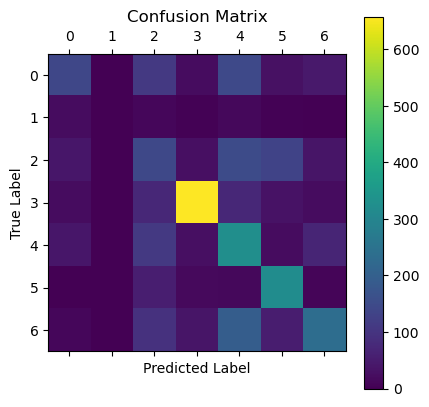

In [26]:
results = np.argmax(model.predict(x_test_private),axis=1)
cm = confusion_matrix(np.where(y_test_private == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()